# COSTRUCTING A MODEL USING THE SHYFT API

### Introduction

Aim of this notebook is to introduce a Shyft user to Shyfts's API. The Shfyt API provides all functionality needed to construct a model, calibrate it, and run it. It is also a great way of learing about the "Shyftonic" way of thinking, i.e. getting to Shyft's architecture. 

In order to get to know the Shyft API, a very simple model will be constructed in the course of this notebook.  The model will be fed with a test dataset, run, and calibrated. In the end it is shown how data can be extracted from  the model.
 
To define a model domain, Shyft uses a number of geo-located sub-units, the cells. Each cell has certain properties like land type fraction (glacier fraction, forest fraction, etc.), area, and geo-location. Cells that belong to the same (sub)catchment have the same catchment ID. The simple model we will construct herein will only hold 1 cell, in order to keep the programming effort at a minimum. Nevertheless will the notebook provide you with the skills needed to setup more complex model domains, existing of several catchments, each composed from a large number of cells. It will just a matter of sclaing.

In [1]:
import sys # remove cell before push!
sys.path.insert(0, r"D:\users\felix\pure_api_model\shyft")

Let's start with importing the Shyft API. The SHyft API gives access to all functionality needed to construct a model. We can import it via ...

In [1]:
from shyft import api # import the Shyft API

In addition to the Shyft API, we will import some modules that ease the handling of arrays (numpy module) and plotting (matplotlib library). Besides this, we also import a ready-to-use dataset that provides us with test data that we will use to run the hydrological model.

In [2]:
import numpy as np # for handling arrays
from matplotlib import pyplot as plt # for plotting
from camels_reader import TestData # provides a test data set

Now, we are set up to use the API for constructing a model. But let's first take a quick look to the test data we are using ...

### STEP 0: LOAD AND PLOT TEST DATA

Prior to digging into the Shyft API, we will initialize the test dataset. By initiating the TestData class, a test data set providing all input variables needed to run a hydrologic simulation is constructed.

The variables needed to run a model provided by Shyft are standard meteorologic variables: temperature, precipitation, wind speed, relative humidity, and incoming radiation.

In addition to those variables, observed discharged and the total catchment area are provided by the dataset. For now, these information will be enough to construct a simple model aiming to simulate the discharge of a region.

In [3]:
data = TestData() # constructs an instance of the TestData class...

Let's have a short look on the variables the data set provides by making some simple plots ...

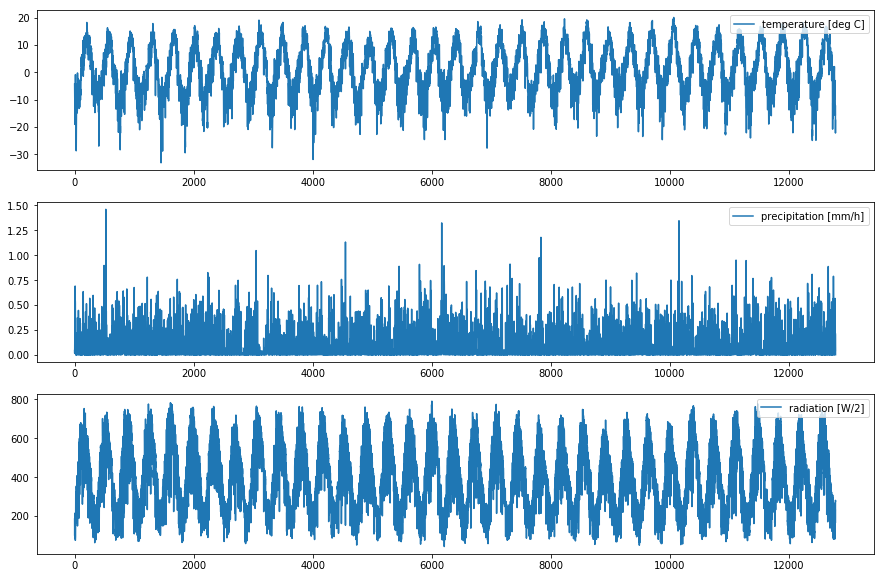

In [4]:
fig, ax = plt.subplots(3, figsize=(15,10))
ax[0].plot(data.temperature, label='temperature [deg C]')
ax[0].legend(loc=1)
ax[1].plot(data.precipitation, label='precipitation [mm/h]')
ax[1].legend(loc=1)
ax[2].plot(data.radiation, label='radiation [W/2]')
ax[2].legend(loc=1)

We have plotted the test data without time reference. The corresponding time vector is also provided in test_data.


In [5]:
print(data.time)
# The time is given in UTC timestamp (seconds since January 1 1970). In this exmaple, the delta t between
# time points is 60*60*3600 seconds. Thus, the dataset holds daily values. By convention, the first data value
# gives the average value defined by the time span between the first and the secon time points given in the time vector.

[ 315532800  315619200  315705600 ... 1419811200 1419897600 1419984000]


### STEP 1a: CHOOSE A MODEL
Shyft has different model types to offer, each of which is composed of a unique sequence of hydrologic methods. We will use the pt_gs_k model, consisting of the Priestly Taylor equation to calculate potential evaportanspiration (PT), a gamma-function based snow routine (GS), and the Kircher method to calculate the discharge response (K).

In [6]:
model_type = api.pt_gs_k.PTGSKModel

# Further model options are:

#model_type = api.pt_ss_k.PTSSKModel
#model_type = api.pt_ss_k.PTHSKModel
#model_type = api.hbv_stack.HbvOptModel
#model_type = api.pt_gs_k.PTGSKOptModel

### STEP 2: DEFINE THE MODEL DOMAIN

Region, catchment, and cells in Shyft:
Configuring the model domain

As introduced earlier, a model domain is costructed of cells, which then are grouped to catchments using a catchment ID.
A cell is characterized by a mid-point (x,y,z), area, land type fractions (glacier, forest, etc), and assigned to a catchment via a catchment ID.

Let's construct a cell:


In [7]:
x, y, z = 0, 0, 0  # cell center coordinates [m]
area = data.area  # cell area [m2]
cid = 1  # cell's catchment ID
mid_point = api.GeoPoint(x, y, z) # mid point Class
glacier = 0.0  # areal glacier fraction
lake = 0.0
reservoir = 0.0
forest = 0.0
unspecified = 1.0  # residual: 1 - glacier - lake - reservoir - forest
radiation_slope_factor = 1.0  # A factor to correct radiation input according to cell slope
ltf = api.LandTypeFractions(glacier, lake, reservoir, forest, unspecified)  # Class to handle land type fractions
geo_cell_data = api.GeoCellData(mid_point, area, cid, radiation_slope_factor, ltf)  # Handls all cell data
cell = model_type.cell_t()  # Constructing a cell
cell.geo = geo_cell_data  # Feeding the cell with data

# Append cells to a cell vector... here only shown for the one cell. In more complex scenarios, many more cells are used to define a domain.
cell_vector = model_type.cell_t.vector_t()
cell_vector.append(cell)

### STEP 3: CONFIGURE THE MODEL

Model specific parameters define how the model equations will respond to a certain meteorologic forcing.
As the parameters are specific to the model type, we can get the correct parameters directly from the model Class.

We differ between region parameters (all cells in a domain have the same parameters), and catchment parameters
(certain (sub)catchments of the domain can be characterized by a set of model parameters different than the region parameters).

Let's construct region parameters suiting our model.

In [8]:
region_parameter = model_type.parameter_t() # constructing region parameters

# and also catchment parameters
catchment_parameters = model_type.parameter_t.map_t() # Constructing a parameter map, that maps a set of parameters to a catchment ID
catchment_parameters[1] = region_parameter # same type as region parameters. We map catchment parameters to the cell with catchment ID 1

### STEP 4: Contructing the region model

    
    
    

In [9]:
# The region model combines information about the model domain, or region,
# which is provided by the cells, and the model we want to use.
# The link between a region and the model are the region (or catchment) specific model parameters.
region_model = model_type(cell_vector, region_parameter, catchment_parameters) # needs all the information from above


### STEP 5: FEED FORCING DATA TO THE REGION MODEL BY CONSTRUCTING A REGION ENVIRONMENT

Before running a simulation, we need to feed forcing data to the region model.
This is done by constructing forcing data time series that are geo-located, so called "sources".
In order to create time series of forcing data, we need to define a time axis, and then combine it with
the data values.

In order to add sources to the region model, collections of sources of a certain
type (temperature, precipitation, ...) are organized in SourceVectors.
These SourceVectors are then added to the region model.

We first initiate a time-axis from the time points to which the source data corresponds by first constructing a time vector, ...

In [10]:
time_vec = api.UtcTimeVector(data.time) # convert the interger array to a shyft time vector

 ... and then constructing a time-axis.
  
 A time axis if a set if non-overlapping periods!
 
 The time points that we have available give the start and end points of those periods.
 In order to have the same amount of perdios as data values, we need to add one more time point the denotes
 the end of the last period of the time axis. Since the time resultution of our data is daily, we simply add
 60*60*24 seconds to the last time point provided to define the end point of the last interval.

In [11]:
time_end = time_vec[-1] + 60*60*24 # end of last time interval

now we have all information needed to construct a time axis ...


In [12]:
ta_srs = api.TimeAxisByPoints(time_vec, t_end=time_end)

 ... and make a time series by combining the raw data with the corresponding time-axis.
 
 Since the data values  represent daily average values, we tell the constructor that it should interprete the values as avarage values, by using point interpretation policy provided by Shyft's API (api.POINT_AVERAGE_VALUE). Another option would be api.POINT_INSTANT_VALUE, used in cases where the measured values represent instant values

In [13]:
t_ts = api.TimeSeries(ta_srs, api.DoubleVector.from_numpy(data.temperature), api.POINT_AVERAGE_VALUE)  # time series

We then do exactly the same for rest of the model forcing variables:

In [14]:
p_ts = api.TimeSeries(ta_srs, api.DoubleVector.from_numpy(data.precipitation), api.POINT_AVERAGE_VALUE)
ws_ts = api.TimeSeries(ta_srs, api.DoubleVector.from_numpy(data.wind_speed), api.POINT_AVERAGE_VALUE)
rh_ts = api.TimeSeries(ta_srs, api.DoubleVector.from_numpy(data.relative_humidity), api.POINT_AVERAGE_VALUE)
r_ts = api.TimeSeries(ta_srs, api.DoubleVector.from_numpy(data.radiation), api.POINT_AVERAGE_VALUE)

We now declare the geo locations of our time series. For simplicity we just use the same location for all time series. The coordinates require to be based on a orthogonal corrdinate system (e.g. UTM).

In [15]:
geop = api.GeoPoint(0,0,0) # x,y,z location

Finally, we have all information needed to construct variable-type specific sources by linking geo location and time series:

In [16]:
t_srs = api.TemperatureSource(geop, t_ts)
p_srs = api.PrecipitationSource(geop, p_ts)
ws_srs = api.WindSpeedSource(geop, ws_ts)
rh_srs = api.RelHumSource(geop, rh_ts)
r_srs = api.RadiationSource(geop, r_ts)

In this example we just rely on source per input variable.

However, the most common case is that we have many geo-located time series per forcing variable 
that we would like to use, e.g. from several obervational stations in 
a region or from a gridded forcing data set (numerical weather forecasting model
climate model, gridded observations, etc.).
 
 Before we can feed the sources to the model, we therefore need to construct source vectors,
 which are collections of sources of the same variable type (temperature, precipitation, ...).
 
 Again: for simplicity only one source per vector is appended in this example. Accordingly, many sources
 with different geo locations could be added to the same vector.

In [17]:
# constructing the source vectors
t_srs_vec = api.TemperatureSourceVector([t_srs])
p_srs_vec = api.PrecipitationSourceVector([p_srs])
ws_srs_vec = api.WindSpeedSourceVector([ws_srs])
rh_srs_vec = api.RelHumSourceVector([rh_srs])
r_srs_vec = api.RadiationSourceVector([r_srs])

All information about sources is organized in the region environment.
The region environment is the part of the region model and contains all geo-located sources.

In [18]:
# constructing a region environment from the environment sources:
region_env = api.ARegionEnvironment()
region_env.temperature = t_srs_vec
region_env.precipitation = p_srs_vec
region_env.wind_speed = ws_srs_vec
region_env.rel_hum = rh_srs_vec
region_env.radiation = r_srs_vec

Now that we have created a region environment holding all geo-located time series data that we want to use as model forcing.

We are now ready to update the region model with the freshly costructed region environment:


In [19]:
region_model.region_env = region_env

### STEP 6: RUNNING THE MODEL

In order to be able to run the model, two more requirements need to be fulfilled:

1. Initial values for state variables need to be defined. The starting state needs to be defined in order to make
future prediction of the model state, e.g., tomorrow's amount of snow in a cell can only be calculated if today's amount of snow is known. The amount of snow is a typical state variable and needs to be set prior to a model run
in order to enable a quality calculation forward in time.

2. Since the model-stack is executed cell-by-cell, the source variables (or model forcing
variables: temperature, etc..) need to be interpolated from the source locations to the cell locations,
so that **each cell holds a complete set of forcing variables. These are then used to run the model cell by cell**.

#### 1. The starting model state: updating the current state of the model

We first construct a state that suits to the model. The state will be constructed
with default values for each state varibale.

In [20]:
state = region_model.state_t()

We can update state variables by simply setting the variables to desired values.

In [21]:
state.kirchner.q = 0.8 # Setting the discharge value of the kirchner routine to 0.5 mm/h

The model needs to keep track of which state belongs to which cell. This can be achieved using the state_with_id state tyoe.
You can think of it as a geo-referenced model state, by mapping a certain state to a cell.
A collection of states_with_id can be managed with a state_with_id_vct, the state_with_id vector.

In [22]:
state_with_id = region_model.state_with_id_t() # constructing the state_with_id
state_with_id_vct = region_model.state_with_id_t.vector_t() # constructing the state_with_id vector
state_with_id.state = state # set the state
state_with_id.id = state_with_id.cell_state(cell.geo) # mapping it to the cell
state_with_id_vct.append(state_with_id) # append it to the vector. As we only constructed a one-cell model at the moment,
                                        # we only need to append this one cell.

Now we can update the region model with the cell-states, by passing the state vector to the apply_state() method.
Only cells that have a catchment ID that is member of the list passed as second argument are updated.

In [23]:
region_model.state.apply_state(state_with_id_vct, [1])

Let's check if the value of the state variable that we just tried to update is actually applied.

In [24]:
print(region_model.current_state[0].kirchner.q)

0.8


The current state will change as the model steps forward in time and always represent the model state 
after the last time stepping. Because it changes, it makes sense to store the initial state (which is to this point
the current state of the model), so that it later can be re-set as current state, e.g. in order to repeat
simulations under the same conditions.

In [25]:
region_model.initial_state = region_model.current_state

Since computation time is costy it is possible to disable/enable the collection of state variables for catchments.
Diabeling collection leads to a faster performant of the model, however, the time series of state variables 
are not stored in memmory during a model run, and thus not accessible after a simulation.
Let's enable state collection for this simulation.

In [26]:
region_model.set_state_collection(1, True) # Enabling state collection for all cells with catchment ID 1

#### 2. Running the interpolation

Before running the interpolation, we need to initiate the cell environment. This constructs the environment variables
at the cell level at the temporal resolution of a time-axis argument.

After initiation, all values of the environment variables at the cell level are set to zero.

The interpolation step will then fill each cell's environment variable time series based on the time series provided
in the sources, and in dependence of a set of interpolation parameters, that define how the interpolation is conducted.

Let's first construct the simulation time-axis ...

In [27]:
utc = api.Calendar() # shyft.api calendar, nice for keeping track of time
n_steps = 365*20 # number of steps
ta_sim = api.TimeAxis(utc.time(1990, 9, 1, 0, 0, 0), api.deltahours(24), 365*20)  # simulation time axis, 20 year at daily resolution

... and then initialize the cell environment:

In [28]:
region_model.initialize_cell_environment(ta_sim)

Let's now run the interpolation:

The interpolation spatially and temporally interpolates the environment variables from sources
(charcterized by the by time axis ta_srs and geo-location) to the cells (characterized by
time-axis ta_sim and the cell's mid-point). The region_model is constructed with default interpolation parameters, which we can use for the interpolation.

In [29]:
region_model.interpolate(region_model.interpolation_parameter, region_model.region_env)

True

Let's finally run the model forward in time, as defined by time-axis ta_sim.


In [30]:
region_model.run_cells()

### PLOTTING DISCHARGE

Model results (and states) are **storded in memmory** (and not written to file, as you might know it from other models)
and can be accessed via the region model. Results can be accessed cell by cell, or aggregated at the catchment level. The latter is calculated on demand. A list of catchment IDs can be passed that define if which cells should be included inthe aggregation.

Some of the results can be accessed via the "statistics" attribute of the region model. Let's have a look at the discharge:

In [31]:
q = region_model.statistics.discharge([1]) # A TimeSeries object is returned: the discharge aggregated over cells with ID 1
                                           # Reminder: We have already learned about TimeSeries further up in this notebook

The values of of a TimeSeries can be accessed as follows:

In [32]:
q_vals = q.values

In [33]:
# Let's plot the discharge

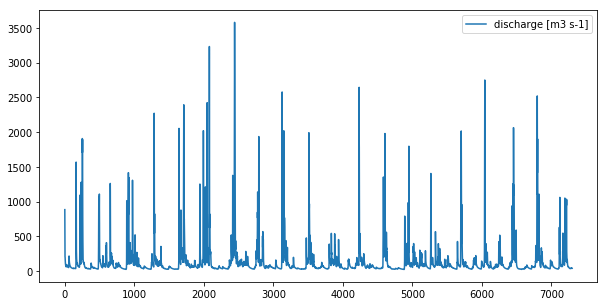

In [34]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(q_vals, label="discharge [m3 s-1]")
ax.legend()

The model is so far run with default model parameters. In order to get a quality simulation, we need to estimate a set of model parameters that lead to a good simulation of the observed discharge of the region. **Let's go and calibrate the model!**

### MODEL CALIBRATION

In order to estimate model parameters, a discharge time series is required that is used to evaluate the simulated discharge. 

The test dataset offers observed discharge of the region. Let's use it to create the evaluation time series, the so called target:

In [35]:
# Target time series from all discharge observations available:
ts_trg_all = api.TimeSeries(ta_srs, data.discharge, api.POINT_AVERAGE_VALUE)

If we would like to limit the evaluation to only a part of the simulation, we can subset the target time series by defining
a new time axis, that only covers a part of the simulation period:

In [36]:
# subset time series to desired time axis for calibration
ta_trg = api.TimeAxis(utc.time(1991, 9, 1, 0, 0, 0), api.deltahours(24), 365*18)  # simulation time axis, 18 years
ts_trg = ts_trg_all.average(ta_trg)

The model needs to know the area that is represented by the target time series. For this reason, "target specifications" are used to combine a target time series with additional properties characterizing the target:

In [37]:
# make target specification vector
calc_type = api.TargetSpecCalcType(0) # Which goal function you want to use; 0 is Nash-Sutcliffe
cids = api.IntVector.from_numpy([1]) # a list with IDs to let the model know which catchments the target represents
weight = 1 # Here we have only one target time series. If you have many, you need to tell the model how to weighten them during calibration
target_specification = api.TargetSpecificationPts(ts_trg, cids, weight, calc_type) # construct the target specification

You can make as many target specifications as you want. They can represent different areas and cover differnt periods.
A collection of target specifications is organized via target specification vectors:

In [38]:
target_spec_vec = api.TargetSpecificationVector()
target_spec_vec.append(target_specification)

As the model will run simulations over and over again during calibration in order to try out differnt parameter sets, it is advantageous if the model runs as fast as possible. Collecting time series of state and response variables slows a model down. As many of these variables are not needed during calibration (e.g. herein, we only use discharge to calibrate the model), Shyft offers an optimized model type that can be used for calibration. This model will discard most of the response and state variables as it steps forwards in time. You can construct an optimized model from the already ready-to-use region model:

In [39]:
region_model_opt = region_model.create_opt_model_clone()

In order to run a calibration, we also need to define the parameter ranges
between which the optimization routine should search for an optimal parameter. Let's construct 3 region model parameter sets: one to define the lower bound parameters, one to define the upper bound parameter, and one which gives the starting values of the parameters, from which an optimization run will start. 

In [40]:
p_min = region_model_opt.parameter_t()
p_max = region_model_opt.parameter_t()
p_init = region_model_opt.parameter_t()

So far, the parameter objects are filled with default values. Let's set the ranges...

In [41]:
# make a difference in parameter range
p_min.kirchner.c1, p_max.kirchner.c1, p_init.kirchner.c1 = -8, -1, -3  # kirchner response parameter
p_min.kirchner.c2, p_max.kirchner.c2, p_init.kirchner.c2 = 0.05, 1.0, 0.4  # kirchner response parameter
p_min.kirchner.c3, p_max.kirchner.c3, p_init.kirchner.c3 = -1, -0.01, -1.0  # kirchner response parameter

p_min.gs.tx, p_max.gs.tx, p_init.gs.tx = -3, 5, 0  # gamma snow, rain/snow threshold temperature [deg. C]
p_min.gs.wind_const, p_max.gs.wind_const, p_init.gs.wind_const = 0, 3, 1.5  # wind scaling for turbulent flux calculations
p_min.gs.wind_scale, p_max.gs.wind_scale, p_init.gs.wind_scale = 1, 6, 3  # wind scaling for turbulent flux calculations

p_min.p_corr.scale_factor, p_max.p_corr.scale_factor, p_init.p_corr.scale_factor = 0.5, 1.2, 1  # precipitation scaling

p_min.ae.ae_scale_factor, p_max.ae.ae_scale_factor, p_init.ae.ae_scale_factor = 0.5, 1.5, 1 # actual evapo scaling

Each optimized model offers an optimizer Class that offers functionality to run an automized calibration. Let's construct it:

In [42]:
optimizer = api.pt_gs_k.PTGSKOptModel.optimizer_t(region_model_opt)

Remember the target we specified earlier? Let's make the otimizer aware of the target, parameter ranges, and the parameter starting values:

In [43]:
optimizer.target_specification = target_spec_vec
optimizer.parameter_lower_bound = p_min
optimizer.parameter_upper_bound = p_max
optimizer.set_verbose_level(1)

We finally can run a calibration!

The optimizer will return an optimized set of parameters once it found the (hopefully) best set of parameters:

In [44]:
print("Calibrating ...")
opt_params = optimizer.optimize(p_init, 1500, 0.2, 1e-5) # calibrateing ... this can take a little while...
print("... done!")

Calibrating ...
... done!


Let's run the model one more time. This time with optimized parameters:

In [45]:
# Running the model with optimized parameters
NSE = 1-optimizer.calculate_goal_function(opt_params)
print("Nash-Sutcliffe efficiency: ", NSE)

Nash-Sutcliffe efficiency:  0.7670065594165228


In [46]:
# Accessing the simulated discharge ...
q_opt = region_model_opt.statistics.discharge([])

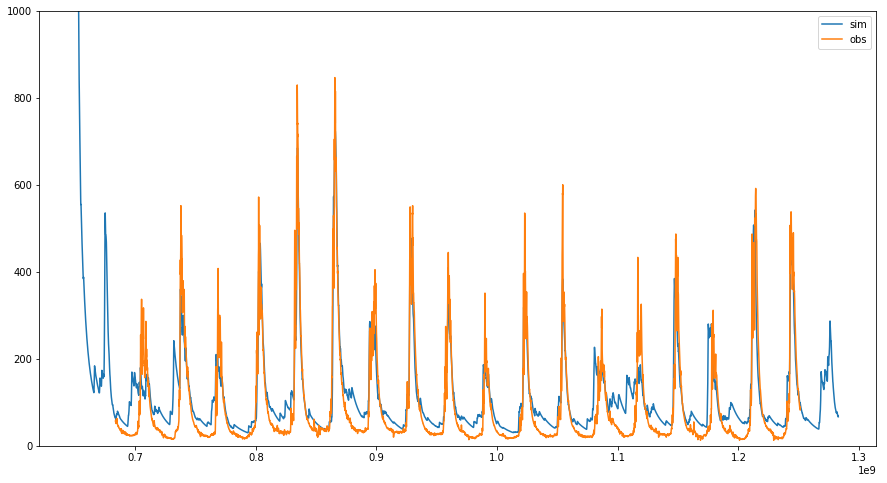

In [47]:
# and plot it, together with the observed discharge:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(q_opt.time_axis.time_points[:-1], q_opt.values, label='sim')
ax.plot(ts_trg.time_axis.time_points[:-1], ts_trg.values, label='obs')
ax.set_ylim([0, 1000])
ax.legend()

#### Congratulation! You're done! You should be able to setup your own Shyft region model, calibrate it, and access simulated data. Try it out:

### Exercise

Construct a region model with 4 cells. Cell 1 and 2 should have catchment ID 1 and cell 3 and 4
should have catchment ID 2, and the following properties:
* cell 1 should have an area of 3390 km2, x:, y:, z:
* cell 2 should have an area of 565 km2, x:, y: z
* cell 3 should have an area of 2260 km2, x:, y:, z:
* cell 4 should have an area of 565 km2, x. y, z:

There are no glaciers, lakes, and reservoirs in the region, but cell 1 is to 50% covered by forest.

Find an optimized set of model parameters for the region (assume that he observed discharge represents the combined discharge of catchment 1 and 2).

Use the optimized region parameters from the calibration in order to simulate the discharge of the region,  and of catchment 1 and 2.

In [48]:
# Start coding here ...